In [8]:
%cd ~/dev/event-camera/src

/home/gianscarpe/dev/event-camera/src


In [9]:
from experimenting.dataset import get_dataloader, DHPJointsDataset, DHP3DJointsDataset
from experimenting.dataset.params_utils import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics, losses

from omegaconf import DictConfig

from experimenting.utils import get_file_paths, plot_heatmap, plot_skeleton_3d, denormalize_predict
import numpy as np

%matplotlib inline

In [10]:
aug = Compose([CenterCrop(256, 256), ToTensor()])


In [11]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = "/data/dhp19/time_count_dataset/labels_full_joints/"
test_subjects = [1, 2, 3, 4, 5]
cams = [3]

batch_size = 16

hparams = DictConfig({'data_dir': data_dir, 'save_split':False, 'labels_dir' :
                      labels_dir, 'test_subjects':test_subjects, 'split_at':0.8, 'cams': cams})
params = get_dataset_params(hparams)

.npy|.mat


In [12]:
d = DHP3DJointsDataset(file_paths = params['file_paths'], labels_dir =
                       labels_dir, indexes=params['test_indexes'], transform=aug)
loader = get_dataloader(d, batch_size, 2)

In [13]:
batch = next(iter(loader))
x, y = batch

# Eval margipose model

In [14]:
%ls /home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel

exp_Adam_0.0003_center_crop_06-16-10-20/  exp_Adam_0.0003_no_aug_06-15-12-02/
exp_Adam_0.0003_no_aug_06-09-15-47/       exp_Adam_0.0003_no_aug_06-15-13-46/
exp_Adam_0.0003_no_aug_06-09-15-49/       exp_Adam_0.0003_no_aug_06-15-13-55/
exp_Adam_0.0003_no_aug_06-10-15-41/       exp_Adam_0.0003_no_aug_06-15-13-56/
exp_Adam_0.0003_no_aug_06-10-15-53/       exp_Adam_0.0003_no_aug_06-15-14-04/
exp_Adam_0.0003_no_aug_06-10-16-12/       exp_Adam_0.0003_no_aug_06-15-15-58/
exp_Adam_0.0003_no_aug_06-10-16-42/       exp_Adam_0.0003_no_aug_06-15-16-06/
exp_Adam_0.0003_no_aug_06-12-12-21/       exp_Adam_0.0003_no_aug_06-15-16-09/
exp_Adam_0.0003_no_aug_06-12-12-22/       exp_Adam_0.0003_no_aug_06-15-16-13/
exp_Adam_0.0003_no_aug_06-12-15-05/       exp_Adam_0.0003_no_aug_06-15-16-33/
exp_Adam_0.0003_no_aug_06-12-15-45/       exp_Adam_0.0003_no_aug_06-15-16-37/
exp_Adam_0.0003_no_aug_06-15-11-16/       exp_Adam_0.0003_no_aug_06-15-16-43/
exp_Adam_0.0003_no_aug_06-15-11-33/       exp_Adam_0.0003_no_aug

In [15]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.utils import get_joints_from_heatmap, average_loss, decompose_projection_matrix

#exp_name = 'exps_HourglassModel/exp_Adam_0.0003_no_aug_05-25-12-57'
exp_name = 'exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-16-10-20'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.MargiposeEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/hydra/_internal/utils.py:480: UserWarning: 
ObjectConf field 'class' is deprecated since Hydra 1.0.0 and will be removed in a future Hydra version.
Offending config class:
	class=experimenting.models.losses.MultiPixelWiseLoss
Change your config to use 'cls' instead of 'class'.

  category=UserWarning,


In [16]:
mpjpe = metrics.MPJPE(reduction=average_loss)


In [17]:
with torch.no_grad():
    preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)

In [18]:
# Load matrix
homedir = '/data/dhp19'
P_mat_dir = os.path.join(homedir, 'P_matrices/')
P_mat_cam3 = np.load(os.path.join(P_mat_dir,'P2.npy'))
K, R, t = decompose_projection_matrix(P_mat_cam3)
M = np.concatenate([R, np.expand_dims(t, 1)], axis=1) 

In [34]:
from importlib import reload
import experimenting.utils.cv_helpers as utils
utils = reload(utils)

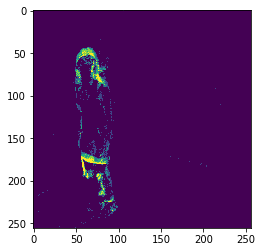

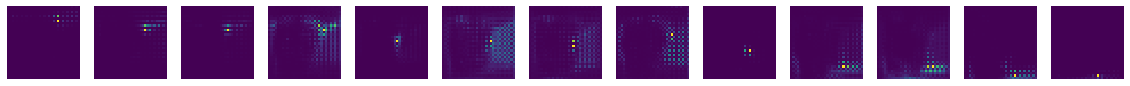

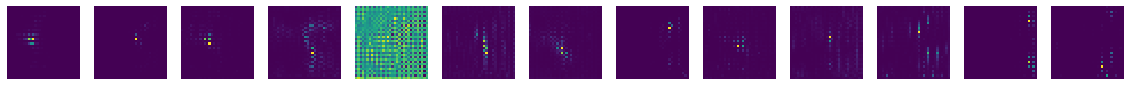

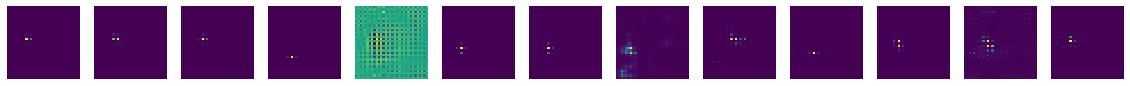

In [72]:
frame = 0
plt.imshow(x[frame].squeeze())
# XY
plot_heatmap(preds[0][-1][frame])

# ZY
plot_heatmap(preds[1][-1][frame])

# XZ
plot_heatmap(preds[2][-1][frame])

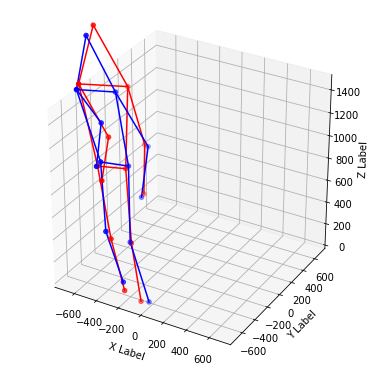

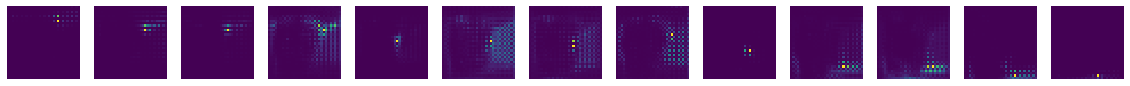

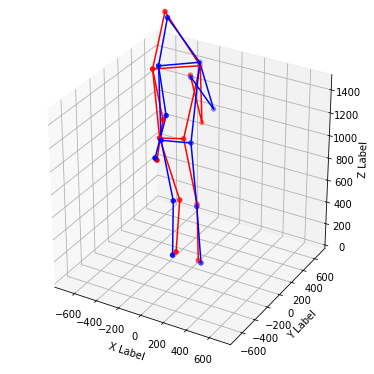

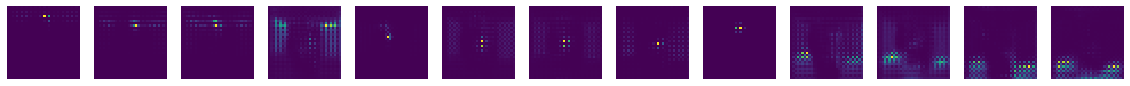

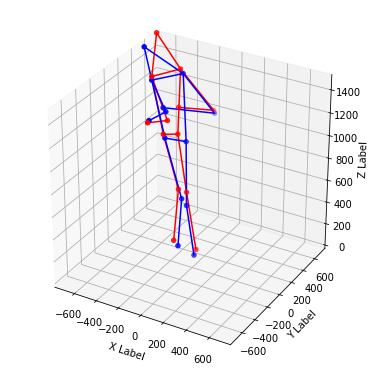

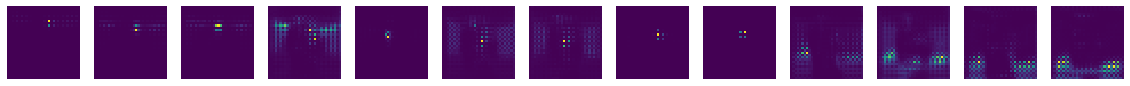

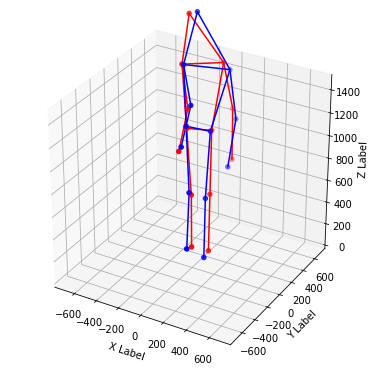

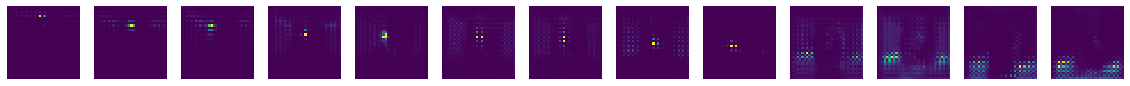

In [71]:
for i in range(4):
    camera = y['camera'][i]
    gt_skeleton = y['skeleton'][i].numpy().swapaxes(1, 0)
    pred_skeleton = normalized_skeletons[i].narrow(-1, 0, 3)
    pred_skeleton = denormalize_predict(pred_skeleton,
                                        256, 256, camera)
    utils.plot_skeleton_3d(gt_skeleton, pred_skeleton, M)

